In [272]:
%matplotlib inline

In [273]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import griddata
from scipy import stats

In [274]:
def smooth_noise(x, spacing=10, interp='linear', rand=np.random):
    if x.ndim == 1:
        x = x[None, ...]
    spaced_indices = [slice(None)] + [list(range(0, n, spacing)) + [n-1]*((n+1)%spacing) for n in x.shape[1:]]
    points = x[spaced_indices].T
    values = rand.rand(points.shape[0])
    noise = griddata(points, values, x, method=interp)
    if noise.shape[0] == 1:
        return noise[0]
    else:
        return noise

def get_interval(p, x, alpha):
    int_min, int_max = np.argmax(p), np.argmax(p)
    step = "min"
    while True:
        if step == "min":
            int_min = max([int_min - 1, 0])
            step = "max"
        else:
            int_max = min(int_max + 1, len(p)-1)
            step = "min"
            
        interval_sum = np.sum(p[int_min:int_max + 1])
                   
        if interval_sum >= alpha:
            break
        if int_min == 0 and int_max == len(p)-1:
            raise ValueError('Interval does not fit in array')
    return [x[int_min], x[int_max]]

In [275]:
k_b = 1.38064852e-23

N_0 = 6.02214076e+23

T = 300

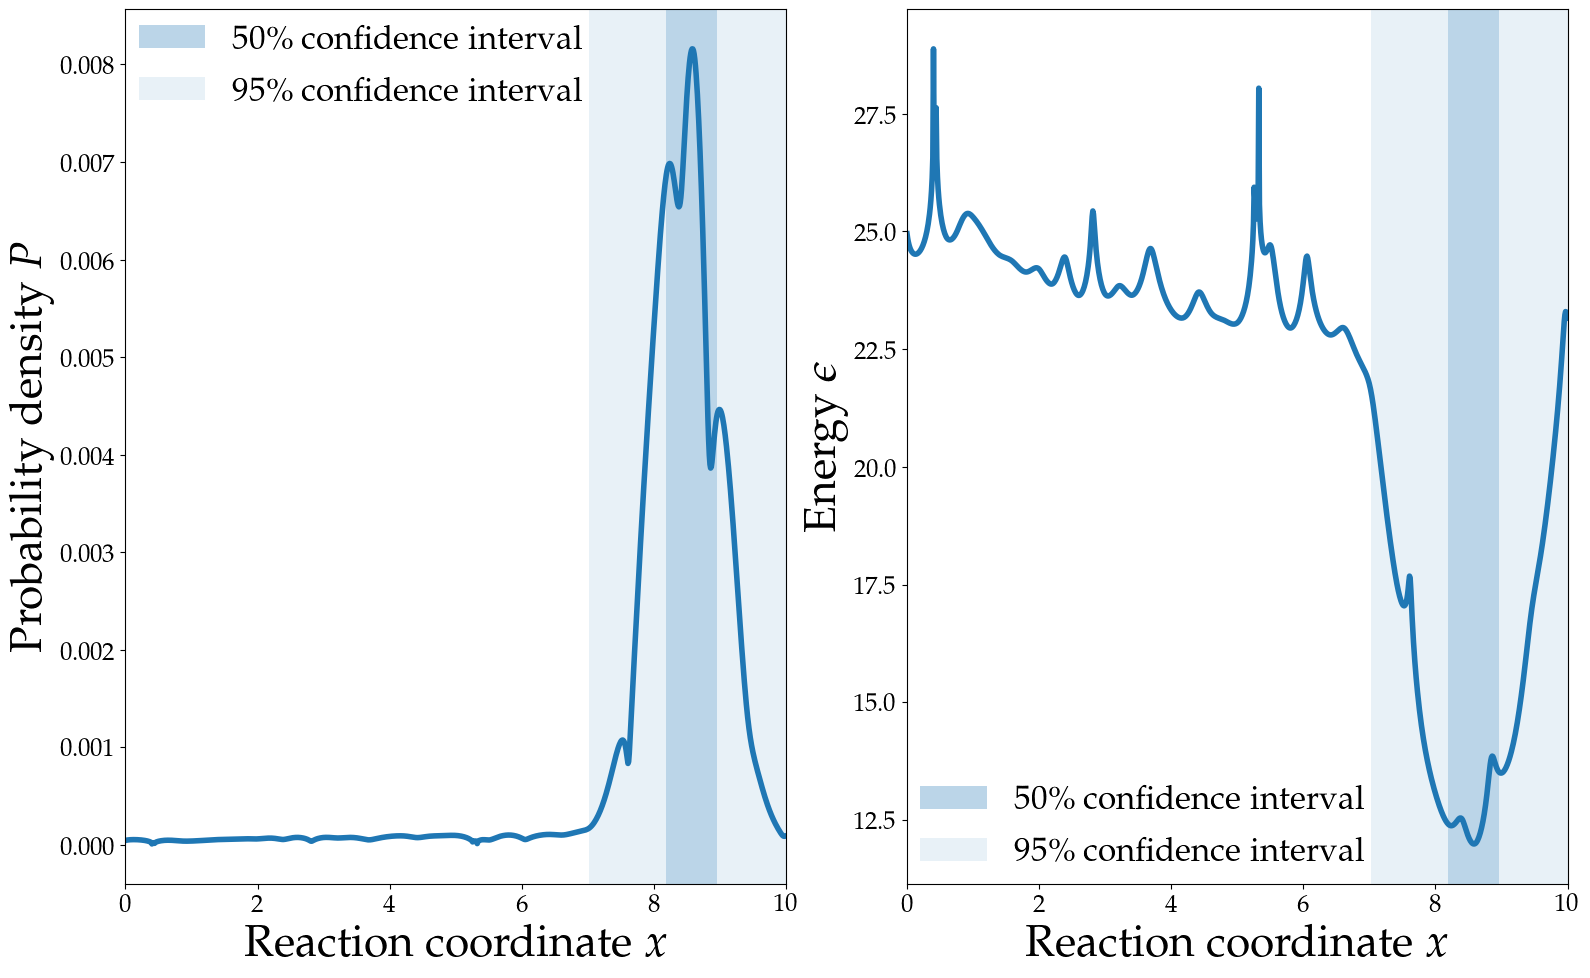

In [276]:
rand = np.random.RandomState(1) 

mpl.rcdefaults()

font = {
    'family': 'serif',
    'serif': 'Palatino',
    'sans-serif': 'Lato',
}

mpl.rcParams['mathtext.fontset'] = 'stix'

plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=32)

width = 16
height = width / 1.618
linewidth = 4

fig = plt.figure()  # a new figure window
ax0 = fig.add_subplot(1, 2, 1)  # specify (nrows, ncols, axnum)
ax1 = fig.add_subplot(1, 2, 2)  # specify (nrows, ncols, axnum)

ax0.set_xlim(0.0, 10.0)
ax1.set_xlim(0.0, 10.0)

min_x = 0
max_x = 10

n = 1000

dist = stats.norm

mean = 8.5

x = np.linspace(min_x, max_x, n)

# x = np.mgrid[min_x:max_x:n*1j, min_x:max_x:n*1j]

noise = smooth_noise(x, spacing=20, rand=rand, interp='cubic')

gauss_a = 1.00 * dist.pdf(x, loc=mean, scale=0.5)
gauss_b = 0.18 * dist.pdf(x, loc=mean, scale=7.0)

likelihood = abs(noise)**0.2 * (gauss_a + gauss_b + 0.1/n)

partition_function = np.sum(likelihood)

p = likelihood/partition_function

e = - k_b * T * (np.log(likelihood) - np.log(partition_function)) * N_0 / 1000

ax0.plot(x, p, linewidth=linewidth)
ax0.set_ylabel('Probability density $P$')
ax0.set_xlabel('Reaction coordinate $x$')

ax1.plot(x, e, linewidth=linewidth)
ax1.set_ylabel('Energy $\epsilon$')
ax1.set_xlabel('Reaction coordinate $x$')

alpha_inner = 0.5
interval_inner = get_interval(p, x, alpha_inner)   

alpha_outer = 0.95
interval_outer = get_interval(p, x, alpha_outer)  

ax0.axvspan(*interval_inner, alpha=0.3, label=f'{alpha_inner*100:.0f}\% confidence interval')
ax1.axvspan(*interval_inner, alpha=0.3, label=f'{alpha_inner*100:.0f}\% confidence interval')

ax0.axvspan(interval_outer[0], interval_inner[0], alpha=0.1, label=f'{alpha_outer*100:.0f}\% confidence interval')
ax0.axvspan(interval_inner[1], interval_outer[1], alpha=0.1)
ax1.axvspan(interval_outer[0], interval_inner[0], alpha=0.1, label=f'{alpha_outer*100:.0f}\% confidence interval')
ax1.axvspan(interval_inner[1], interval_outer[1], alpha=0.1)

ax0.legend(fontsize=24, frameon=False, borderaxespad=0.0)
ax1.legend(fontsize=24, frameon=False, borderaxespad=0.0)

fig.set_size_inches(width, height)
fig.tight_layout(w_pad=0.4)

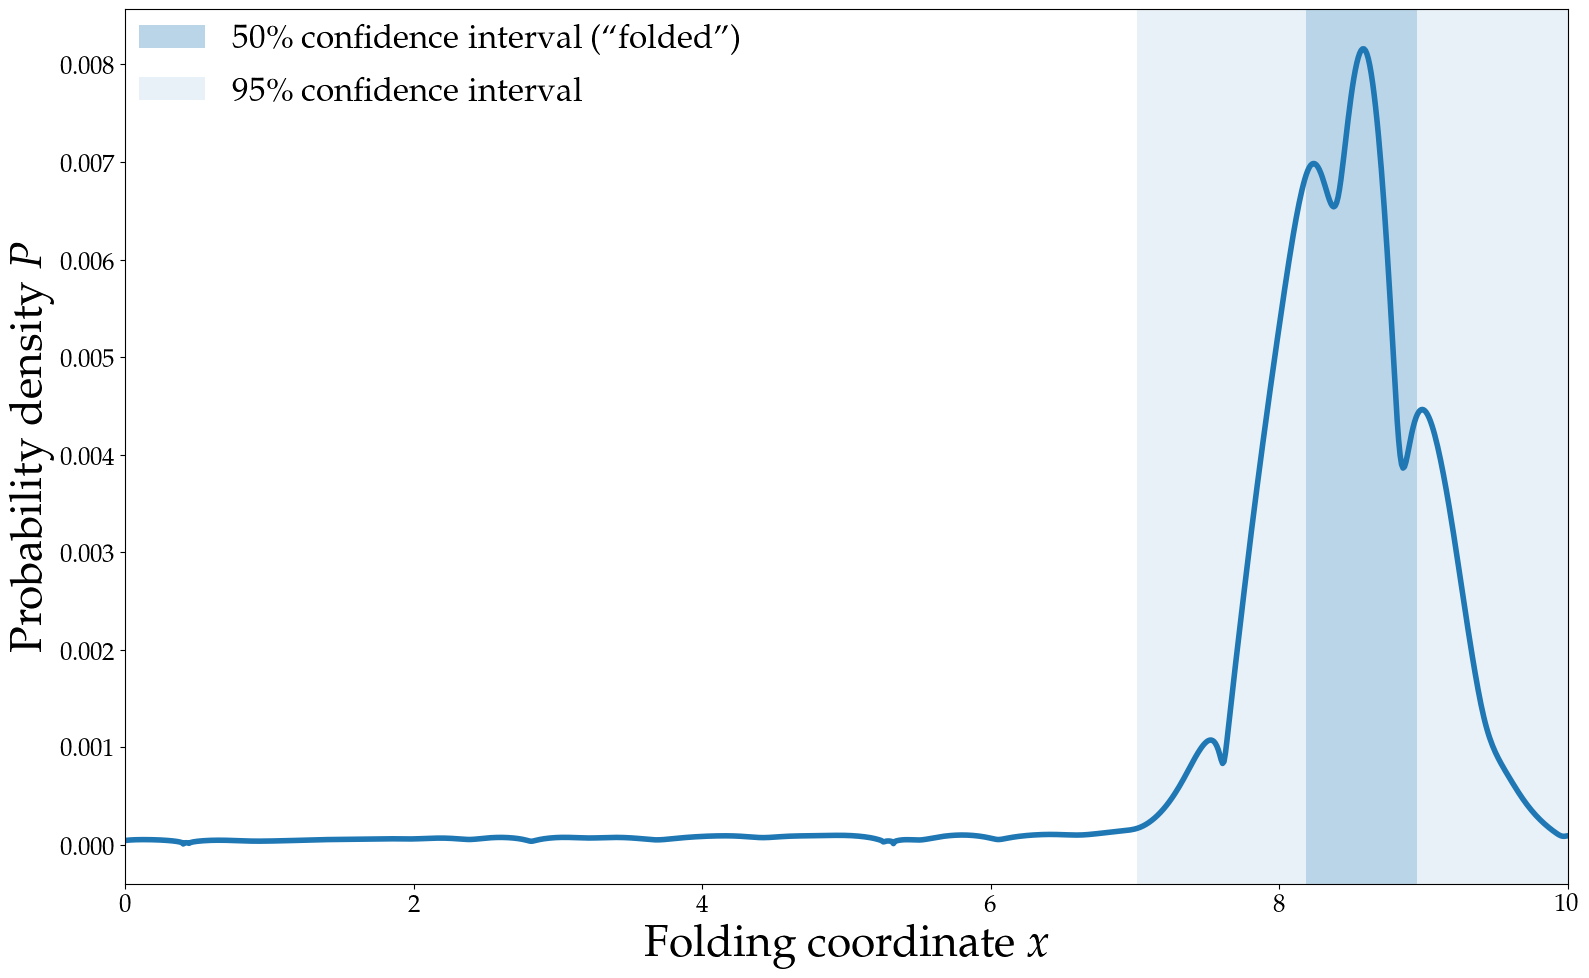

In [271]:
fig = plt.figure()  # a new figure window
ax0 = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)

ax0.set_xlim(0.0, 10.0)

ax0.plot(x, p, linewidth=linewidth)
ax0.set_ylabel('Probability density $P$')
ax0.set_xlabel('Folding coordinate $x$')

alpha_inner = 0.5
interval_inner = get_interval(p, x, alpha_inner)   

alpha_outer = 0.95
interval_outer = get_interval(p, x, alpha_outer)  

ax0.axvspan(*interval_inner, alpha=0.3, label=f"{alpha_inner*100:.0f}\% confidence interval (``folded'')")

ax0.axvspan(interval_outer[0], interval_inner[0], alpha=0.1, label=f'{alpha_outer*100:.0f}\% confidence interval')
ax0.axvspan(interval_inner[1], interval_outer[1], alpha=0.1)

ax0.legend(fontsize=24, frameon=False, borderaxespad=0.0)

fig.set_size_inches(width, height)
fig.tight_layout(w_pad=0.4)